In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
import numpy as np


class NeuralNetwork:
    def __init__(self, epochs=1000, learning_rate=0.01, task="binary"):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.task = task  # "binary" or "regression"

        self.layer_sizes = []
        self.weights = {}
        self.biases = {}

        self.z_values = {}
        self.activations = {}
        self.activation_functions = {}


    #adding the layers

    def add_input_layer(self, input_dim):
        self.layer_sizes.append(input_dim)

    def add_hidden_layer(self, neurons, activation="relu"):
        self.layer_sizes.append(neurons)
        self.activation_functions[len(self.layer_sizes) - 1] = activation

    def add_output_layer(self, neurons):
        self.layer_sizes.append(neurons)

        if self.task == "binary":
            self.activation_functions[len(self.layer_sizes) - 1] = "sigmoid"
        elif self.task == "regression":
            self.activation_functions[len(self.layer_sizes) - 1] = "linear"
        else:
            raise ValueError("Invalid task")

        self._initialize_parameters()


    #parameter initialization
    def _initialize_parameters(self):
        for l in range(1, len(self.layer_sizes)):
            self.weights[f"W{l}"] = np.random.randn(
                self.layer_sizes[l], self.layer_sizes[l - 1]
            ) * np.sqrt(2 / self.layer_sizes[l - 1])  # He init for ReLU

            self.biases[f"b{l}"] = np.zeros((self.layer_sizes[l], 1))


    #activations and their derivatives
    def _activation(self, Z, function):
        if function == "sigmoid":
            return 1 / (1 + np.exp(-Z))
        if function == "relu":
            return np.maximum(0, Z)
        if function == "linear":
            return Z
        raise ValueError("Unsupported activation")

    def _activation_derivative(self, Z, function):
        if function == "sigmoid":
            s = 1 / (1 + np.exp(-Z))
            return s * (1 - s)
        if function == "relu":
            return (Z > 0).astype(float)
        if function == "linear":
            return np.ones_like(Z)
        raise ValueError("Unsupported activation derivative")


    #calculating the loss
    def _calculate_loss(self, y, y_pred):
        eps = 1e-9

        if self.task == "binary":
            y_pred = np.clip(y_pred, eps, 1 - eps)
            return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

        if self.task == "regression":
            return np.mean((y - y_pred) ** 2)


    #forward propagation
    def forward_propagation(self, X):
        self.activations["a0"] = X

        for l in range(1, len(self.layer_sizes)):
            Z = self.weights[f"W{l}"] @ self.activations[f"a{l-1}"] + self.biases[f"b{l}"]
            self.z_values[f"z{l}"] = Z
            self.activations[f"a{l}"] = self._activation(
                Z, self.activation_functions[l]
            )

        return self.activations[f"a{len(self.layer_sizes) - 1}"]



    def backward_propagation(self, y):
        deltas = {}
        L = len(self.layer_sizes) - 1

        #output delta
        aL = self.activations[f"a{L}"]

        if self.task == "binary":
            deltas[f"d{L}"] = aL - y
        elif self.task == "regression":
            deltas[f"d{L}"] = aL - y

       #hidden layers
        for l in range(L - 1, 0, -1):
            deltas[f"d{l}"] = (
                self.weights[f"W{l+1}"].T @ deltas[f"d{l+1}"]
            ) * self._activation_derivative(
                self.z_values[f"z{l}"], self.activation_functions[l]
            )

       #update parameters
        for l in range(1, L + 1):
            self.weights[f"W{l}"] -= self.learning_rate * (
                deltas[f"d{l}"] @ self.activations[f"a{l-1}"].T
            )
            self.biases[f"b{l}"] -= self.learning_rate * deltas[f"d{l}"]


    #Training the model
    def fit(self, X, y):
        for epoch in range(self.epochs):
            epoch_loss = 0

            for i in range(X.shape[0]):
                X_i = X[i].reshape(-1, 1)
                y_i = y[i].reshape(-1, 1)

                y_pred = self.forward_propagation(X_i)
                epoch_loss += self._calculate_loss(y_i.T, y_pred.T)
                self.backward_propagation(y_i)

            epoch_loss /= X.shape[0]

            if epoch % 100 == 0:
                print(f"Epoch {epoch:4d} | Loss = {epoch_loss:.6f}")


    #predicting the target variable
    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            y_pred = self.forward_propagation(X[i].reshape(-1, 1))
            preds.append(y_pred.flatten())

        preds = np.array(preds)

        if self.task == "binary":
            return np.where(preds > 0.5, 1, 0)
        return preds
    def display(self):
        print("\nNeural Network Architecture")
        print("-" * 40)

        # Input layer
        print(f"Layer 0 (Input)  : {self.layer_sizes[0]} neurons")

        # Hidden + Output layers
        for l in range(1, len(self.layer_sizes)):
            layer_type = "Output" if l == len(self.layer_sizes) - 1 else "Hidden"
            activation = self.activation_functions[l]

            print(
                f"Layer {l} ({layer_type}) : {self.layer_sizes[l]} neurons "
                f"| Activation = {activation}"
            )

        print("\nTrainable Parameters")
        print("-" * 40)

        for l in range(1, len(self.layer_sizes)):
            print(
                f"W{l} shape: {self.weights[f'W{l}'].shape} | "
                f"b{l} shape: {self.biases[f'b{l}'].shape}"
            )

        print("-" * 40)


In [50]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure()

    # Determine contour level and scatter labels based on model type
    y_flat = y.flatten()
    if isinstance(model, NeuralNetwork):
        contour_level = 0.5 # Neural network outputs probabilities 0-1, boundary is typically 0.5
        class_labels = [0, 1] # Neural network trained with 0 and 1

    plt.contourf(xx, yy, Z > contour_level, alpha=0.25, cmap="bwr")
    plt.contour(xx, yy, Z, levels=[contour_level], colors='k', linestyles='--')

    for label in class_labels:
        plt.scatter(X[y_flat == label][:, 0], X[y_flat == label][:, 1], label=f'Class {label}')


    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.show()

#XOR Data

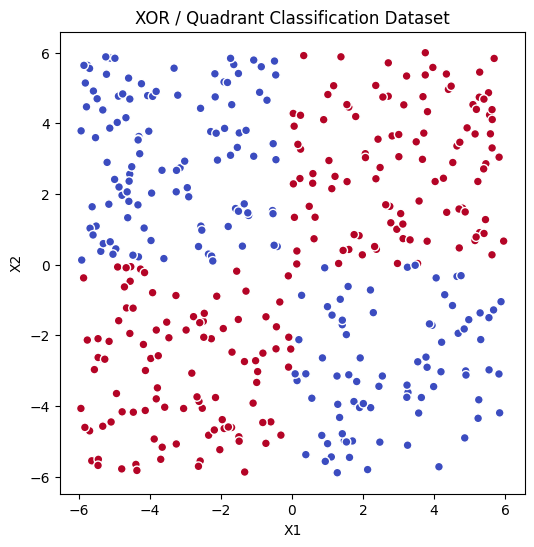

In [51]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_samples = 400

# Generate random points
X = np.random.uniform(-6, 6, size=(n_samples, 2))

# XOR-like labels
y = np.where(X[:, 0] * X[:, 1] > 0, 1, 0)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(
    X[:, 0], X[:, 1],
    c=y,
    cmap="coolwarm",
    edgecolors="white",
    s=40
)

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("XOR / Quadrant Classification Dataset")
plt.show()


In [52]:
nn = NeuralNetwork(
    epochs=1000,
    learning_rate=0.01,

)

nn.add_input_layer(2)
nn.add_hidden_layer(16, activation="relu")
nn.add_hidden_layer(8, activation="relu")
nn.add_output_layer(1)

nn.display()


Neural Network Architecture
----------------------------------------
Layer 0 (Input)  : 2 neurons
Layer 1 (Hidden) : 16 neurons | Activation = relu
Layer 2 (Hidden) : 8 neurons | Activation = relu
Layer 3 (Output) : 1 neurons | Activation = sigmoid

Trainable Parameters
----------------------------------------
W1 shape: (16, 2) | b1 shape: (16, 1)
W2 shape: (8, 16) | b2 shape: (8, 1)
W3 shape: (1, 8) | b3 shape: (1, 1)
----------------------------------------


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.20,
    random_state=42,
)

In [54]:
nn.fit(X_train, y_train.reshape(-1, 1))

Epoch    0 | Loss = 0.246770
Epoch  100 | Loss = 0.021604
Epoch  200 | Loss = 0.013136
Epoch  300 | Loss = 0.004481
Epoch  400 | Loss = 0.002074
Epoch  500 | Loss = 0.007817
Epoch  600 | Loss = 0.005065
Epoch  700 | Loss = 0.004579
Epoch  800 | Loss = 0.012115
Epoch  900 | Loss = 0.010744


In [55]:
from sklearn.metrics import accuracy_score
y_pred=nn.predict(X_test)
print("accuracy score of the model is: ",accuracy_score(y_pred,y_test))

accuracy score of the model is:  0.9875


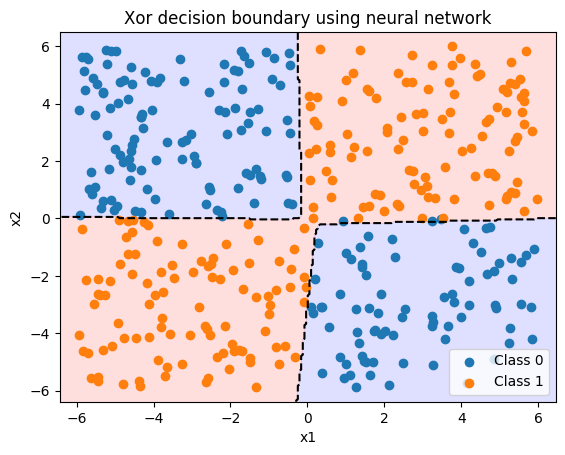

In [56]:
plot_decision_boundary(X,y,nn,"Xor decision boundary using neural network")

#Working With The regression Problem

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate input feature (1D)
X = np.linspace(-3, 3, 200).reshape(-1, 1)

# Generate non-linear target with noise
y = (
    0.5 * X**2
    + np.sin(2 * X)
    + np.random.normal(0, 0.3, size=X.shape)
)

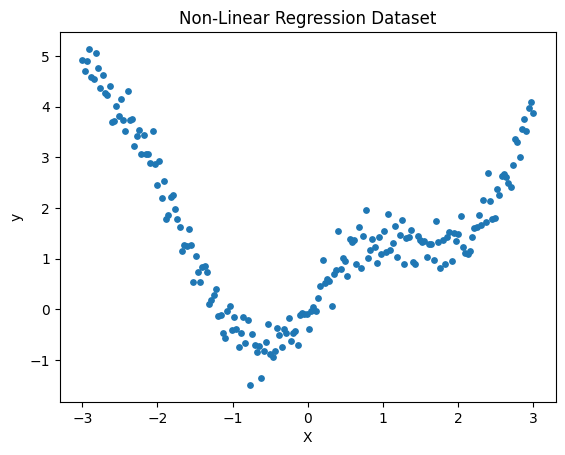

In [58]:
# Plot the dataset
plt.scatter(X, y, s=15)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Non-Linear Regression Dataset")
plt.show()


In [59]:
nn = NeuralNetwork(
    epochs=1000,
    learning_rate=0.01,
    task="regression"
)

nn.add_input_layer(1)
nn.add_hidden_layer(16, activation="relu")
nn.add_hidden_layer(8, activation="relu")
nn.add_output_layer(1)


In [60]:
nn.display()


Neural Network Architecture
----------------------------------------
Layer 0 (Input)  : 1 neurons
Layer 1 (Hidden) : 16 neurons | Activation = relu
Layer 2 (Hidden) : 8 neurons | Activation = relu
Layer 3 (Output) : 1 neurons | Activation = linear

Trainable Parameters
----------------------------------------
W1 shape: (16, 1) | b1 shape: (16, 1)
W2 shape: (8, 16) | b2 shape: (8, 1)
W3 shape: (1, 8) | b3 shape: (1, 1)
----------------------------------------


In [61]:
nn.display()


Neural Network Architecture
----------------------------------------
Layer 0 (Input)  : 1 neurons
Layer 1 (Hidden) : 16 neurons | Activation = relu
Layer 2 (Hidden) : 8 neurons | Activation = relu
Layer 3 (Output) : 1 neurons | Activation = linear

Trainable Parameters
----------------------------------------
W1 shape: (16, 1) | b1 shape: (16, 1)
W2 shape: (8, 16) | b2 shape: (8, 1)
W3 shape: (1, 8) | b3 shape: (1, 1)
----------------------------------------


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

nn.fit(X_train,y_train)

Epoch    0 | Loss = 1.396527
Epoch  100 | Loss = 0.208036
Epoch  200 | Loss = 0.192756
Epoch  300 | Loss = 0.108124
Epoch  400 | Loss = 0.093134
Epoch  500 | Loss = 0.089137
Epoch  600 | Loss = 0.087735
Epoch  700 | Loss = 0.086275
Epoch  800 | Loss = 0.085302
Epoch  900 | Loss = 0.084573


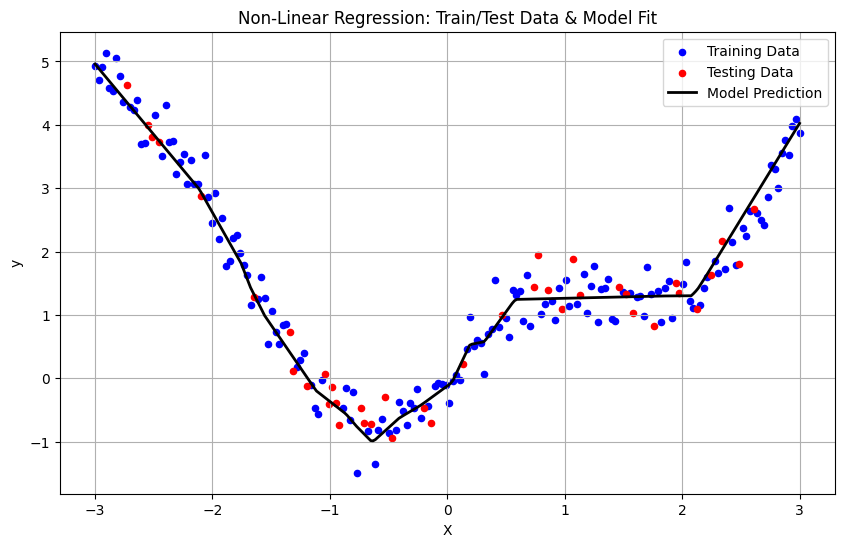

In [63]:

plt.figure(figsize=(10, 6))

# Training data
plt.scatter(X_train, y_train, color="blue", label="Training Data", s=20)

# Testing data
plt.scatter(X_test, y_test, color="red", label="Testing Data", s=20)


X_curve = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)


y_curve = nn.predict(X_curve)   # nn is your trained model

# Plot prediction curve
plt.plot(X_curve, y_curve, color="black", linewidth=2, label="Model Prediction")

# Labels
plt.xlabel("X")
plt.ylabel("y")
plt.title("Non-Linear Regression: Train/Test Data & Model Fit")
plt.legend()
plt.grid(True)
plt.show()

In [64]:
#r2 score of the model
from sklearn.metrics import r2_score
y_pred=nn.predict(X_test)
print("r2 score of the model is: ",r2_score(y_test,y_pred))

r2 score of the model is:  0.9601133162627137
